ODI Match Winner : Weekend Hackathon 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Importing the packages and dataset

import numpy as np
import pandas as pd
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Exploring the dataset

train_df = pd.read_csv('/content/drive/My Drive/Hackathon/ODI_Participants_Data/Train.csv')   #(2508, 10) 
target = train_df['MatchWinner']
train_df.drop(['MatchWinner'],1,inplace=True)

test_df = pd.read_csv('/content/drive/My Drive/Hackathon/ODI_Participants_Data/Test.csv')     #(1075, 9)

dataset = pd.concat([train_df, test_df], axis=0, sort=False)

print(dataset.shape)

dataset.head()

(3583, 9)


,Team1,Team2,Stadium,HostCountry,Team1_Venue,Team2_Venue,Team1_Innings,Team2_Innings,MonthOfMatch
0,5,4,37,4,Home,Away,Second,First,Dec
1,1,14,84,7,Neutral,Neutral,First,Second,Sep
2,9,15,47,9,Home,Away,First,Second,Feb
3,7,2,102,6,Home,Away,First,Second,Aug
4,6,8,46,5,Home,Away,First,Second,Aug


In [4]:
#Let's see the details of the dataset
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3583 entries, 0 to 1074
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Team1          3583 non-null   int64 
 1   Team2          3583 non-null   int64 
 2   Stadium        3583 non-null   int64 
 3   HostCountry    3583 non-null   int64 
 4   Team1_Venue    3583 non-null   object
 5   Team2_Venue    3583 non-null   object
 6   Team1_Innings  3583 non-null   object
 7   Team2_Innings  3583 non-null   object
 8   MonthOfMatch   3583 non-null   object
dtypes: int64(4), object(5)
memory usage: 279.9+ KB
None


There are no blanks in any of the feature columns and hence we can go ahead with further pipeline

In [5]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Team1,3583.0,7.304773,4.656641,0.0,4.0,7.0,12.0,15.0
Team2,3583.0,9.164387,4.560046,0.0,5.0,10.0,13.0,15.0
Stadium,3583.0,72.730394,43.588258,0.0,36.0,69.0,111.0,151.0
HostCountry,3583.0,7.566285,5.618924,0.0,3.0,9.0,13.0,16.0


For model building with Sci-kit learn we need to have the variables as 

*   List item
*   List item

numerical values. 

However,we have few variables with the text columns. We are going to dummify these categorical columns before building network on it.

In [6]:
dataset['MonthOfMatch'] = pd.to_datetime(dataset.MonthOfMatch, format='%b').dt.month
print(dataset.MonthOfMatch.unique())



[12  9  2  8 11  5  1  6  4 10  3  7]


In [7]:
print(dataset.head())

   Team1  Team2  Stadium  ...  Team1_Innings Team2_Innings MonthOfMatch
0      5      4       37  ...         Second         First           12
1      1     14       84  ...          First        Second            9
2      9     15       47  ...          First        Second            2
3      7      2      102  ...          First        Second            8
4      6      8       46  ...          First        Second            8

[5 rows x 9 columns]


In [8]:
# All the categorical columns

var_mod = ['Team1_Venue','Team2_Venue','Team1_Innings','Team2_Innings']

# Dataframe of all the categorical columns
categorical_cols=dataset[var_mod]
categorical_cols.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3583 entries, 0 to 1074
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Team1_Venue    3583 non-null   object
 1   Team2_Venue    3583 non-null   object
 2   Team1_Innings  3583 non-null   object
 3   Team2_Innings  3583 non-null   object
dtypes: object(4)
memory usage: 140.0+ KB


In [9]:
dummy_encoded_dataset = pd.get_dummies(categorical_cols,drop_first=True)
print(dummy_encoded_dataset.shape)
print(dummy_encoded_dataset.columns)

(3583, 6)
Index(['Team1_Venue_Home', 'Team1_Venue_Neutral', 'Team2_Venue_Home',
       'Team2_Venue_Neutral', 'Team1_Innings_Second', 'Team2_Innings_Second'],
      dtype='object')


In [10]:
#Let's check the shape of df_train before merging it with dummy_encoded_df_train
dataset.shape

(3583, 9)

In [11]:
#Let's merge dummy_encoded_df_train with df_train

dataset2 = pd.concat([dataset,dummy_encoded_dataset],1)
dataset2.shape

(3583, 15)


You can see that the number of columns have increased from 9 to 15 after one hot encoding.

Let's drop the categorical columns now, as we have their dummified columns as well.

In [12]:
drop_categorical_cols = dataset[var_mod]

#Let's drop var_mod from onehot_encoded_dataset
dataset2.drop(drop_categorical_cols,1,inplace=True)

#dataset2 is our new dataframe
print(dataset2.shape)

(3583, 11)


**Understand co-relation between variables**

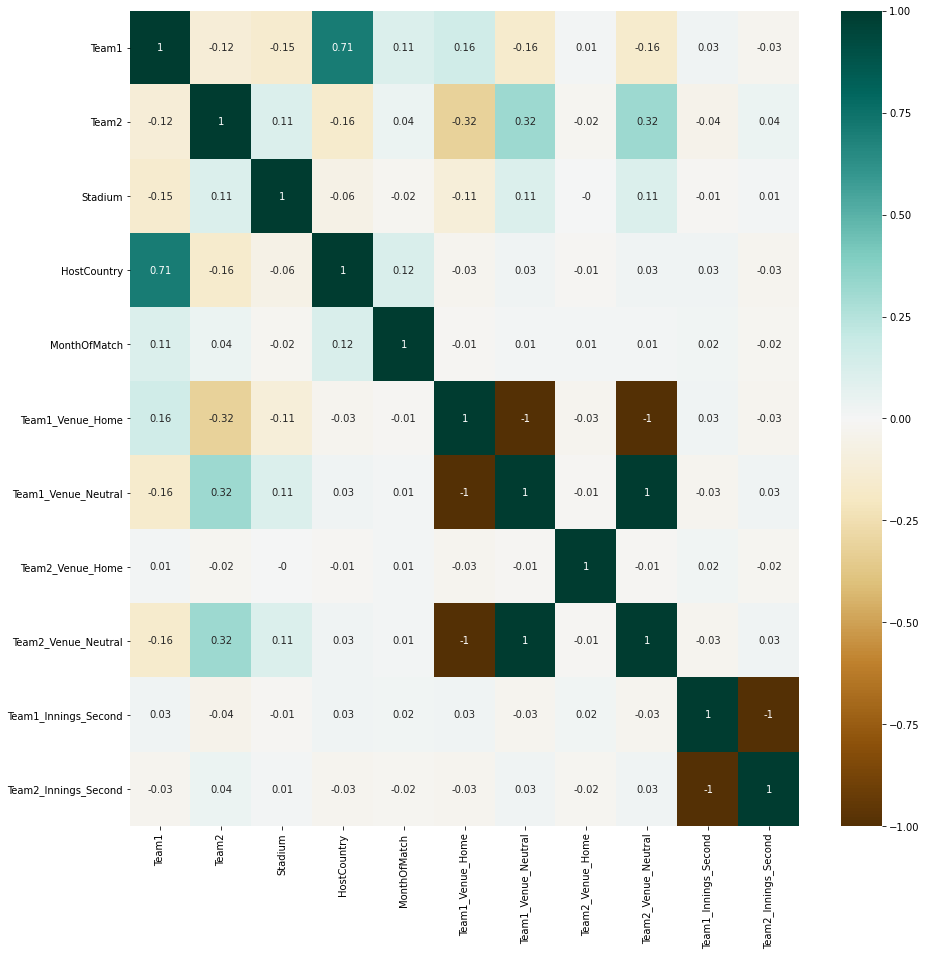

In [13]:
#Let's plot correlation map
corr_dataset2 = dataset2.corr().round(2)

plt.figure(figsize=(15,15))
sns.heatmap(corr_dataset2,cmap="BrBG",annot=True)

In [14]:
# Create correlation matrix
corr_matrix = dataset2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.80)]

# Drop features 
dataset2.drop(to_drop, axis=1, inplace=True)

dataset2.head()

,Team1,Team2,Stadium,HostCountry,MonthOfMatch,Team1_Venue_Home,Team2_Venue_Home,Team1_Innings_Second
0,5,4,37,4,12,1,0,1
1,1,14,84,7,9,0,0,0
2,9,15,47,9,2,1,0,0
3,7,2,102,6,8,1,0,0
4,6,8,46,5,8,1,0,0


**Creating Train and Validation Data**

In this step we are going to create data models that are capable of predicting the Employee attrition. Inorder to create these models first we split the given Train dataset into Train and Validation datasets. 

Train dataset is the one which have the features. We will train the model based on these values to validate the Validation dataset values.

Let's split the data into training and validation datasets

In [15]:
#Scaling and normalization 
from sklearn.preprocessing import StandardScaler
ss=StandardScaler()

feature_set=ss.fit_transform(dataset2)

In [1]:
#Spliting the dataset into training and testing sets 
df_train = (feature_set[:2508])   #Used for training the model
df_test = (feature_set[2508:])    #Used as a final file for prediction

features=df_train
print(features.shape)
print(target.shape)
print(df_test.shape)

NameError: ignored

In [17]:
#Split input and output into desired splits of train and validation
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.20,random_state=1234)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2006, 8)
(2006,)
(502, 8)
(502,)


Entire dataset has been splitted into Train and Test datasets X_train and X_test respectively. 


Build model


In [18]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB() 
gnb.fit(X_train, y_train) 
  
# making predictions on the testing set 
y_pred_gnb = gnb.predict(X_test) 
  
# comparing actual response values (y_test) with predicted response values (y_pred) 
from sklearn import metrics 
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred_gnb)*100)
print("Gaussian Naive Bayes model precision(in %):", metrics.precision_score(y_test, y_pred_gnb,average='weighted')*100)
print("Gaussian Naive Bayes model recall(in %):", metrics.recall_score(y_test, y_pred_gnb,average='weighted')*100)


Gaussian Naive Bayes model accuracy(in %): 31.872509960159363
Gaussian Naive Bayes model precision(in %): 26.859659473868554
Gaussian Naive Bayes model recall(in %): 31.872509960159363


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XGBoost Regression Model


In [19]:
#Importing SVM algorithm from sklearn package
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# Fitting XGBoost to the Training set with hyperparameter tuning 

# Fitting XGBoost to the Training set
import xgboost

classifier = xgboost.XGBClassifier()

classifier2 = xgboost.XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 0.4,
                      subsample = 0.8,
                      objective='binary:logistic', 
                      n_estimators=1000, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=10) 

classifier2.fit(X_train, y_train)

# Predicting the Test set results
pred_boost2 = classifier2.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_boost2)

# Applying k-Fold Cross Validation
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)


print("Accuracy Score : ",accuracy_score(y_test, pred_boost2))
print("Precision Score : ",precision_score(y_test, pred_boost2, 
                                           pos_label='positive',
                                           average='micro'))
print("Recall Score : ",recall_score(y_test, pred_boost2, 
                                           pos_label='positive',
                                           average='micro'))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy Score :  0.6095617529880478
Precision Score :  0.6095617529880478
Recall Score :  0.6095617529880478


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1321: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  % (pos_label, average), UserWarning)


In [20]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(classifier2) 
  
# Load the pickled model 
model_from_pickle = pickle.loads(saved_model) 
  
# Use the loaded pickled model to make predictions 
result = model_from_pickle.predict(df_test)      #np.array
print(result)


[ 2  1 10 ...  5 10  5]


In [21]:

#Converting the result variable to dataframe
submission = pd.DataFrame(result)
submission

,0
0,2
1,1
2,10
3,9
4,5
...,...
1070,5
1071,1
1072,5
1073,10


In [22]:
df_test = pd.DataFrame(df_test)
df_test.head()

,0,1,2,3,4,5,6,7
0,-1.139343,-1.132688,-0.888675,-1.168765,1.110373,0.629985,-0.016708,-1.023440
1,1.437981,-1.790668,-1.232853,1.323163,-0.752953,0.629985,-0.016708,-1.023440
2,0.364096,0.183272,1.314060,1.145168,1.642752,-1.587339,-0.016708,0.977097
3,0.364096,0.183272,-1.485249,0.255194,1.642752,0.629985,-0.016708,-1.023440
4,-0.495012,1.279905,1.314060,1.145168,1.110373,-1.587339,-0.016708,-1.023440


In [23]:
final_pred = pd.concat([df_test, submission], axis=1, sort=False)
print(final_pred.shape)

final_pred

(1075, 9)


,0,1,2,3,4,5,6,7,0
0,-1.139343,-1.132688,-0.888675,-1.168765,1.110373,0.629985,-0.016708,-1.023440,2
1,1.437981,-1.790668,-1.232853,1.323163,-0.752953,0.629985,-0.016708,-1.023440,1
2,0.364096,0.183272,1.314060,1.145168,1.642752,-1.587339,-0.016708,0.977097,10
3,0.364096,0.183272,-1.485249,0.255194,1.642752,0.629985,-0.016708,-1.023440,9
4,-0.495012,1.279905,1.314060,1.145168,1.110373,-1.587339,-0.016708,-1.023440,5
...,...,...,...,...,...,...,...,...,...
1070,1.652758,-0.913361,-0.200320,1.501158,0.045615,0.629985,-0.016708,-1.023440,5
1071,-1.354120,0.621925,0.510980,-1.346760,-1.019142,0.629985,-0.016708,-1.023440,1
1072,-0.495012,0.183272,-0.682169,-1.168765,-0.752953,-1.587339,-0.016708,-1.023440,5
1073,0.578873,0.841252,0.878102,-1.346760,-0.752953,-1.587339,-0.016708,0.977097,10


________________________________

In [24]:
# Importing the packages for Decision Tree Classifier

from sklearn import tree
dtree = tree.DecisionTreeClassifier(criterion="entropy", max_depth=3, random_state=42)
dtree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [35]:
#5.1 Training Decision Tree Model

# Fit the decision tree model on your features and label

dtree.fit(features, target)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [36]:
# The feature_importances_ attribute make it simple to interpret the significance of the predictors you include

list(zip(dtree.feature_importances_))

[(0.6449674129354491,),
 (0.3550325870645508,),
 (0.0,),
 (0.0,),
 (0.0,),
 (0.0,),
 (0.0,),
 (0.0,)]

In [37]:
# The accuracy of the model

print(dtree.score(features,target))

0.36443381180223283


Predictions from Decision Tree Model

In [38]:
# Predictions from Decision Tree Model

y_pred = dtree.predict(df_test)

In [39]:
#Print Confusion matrix on Train Data
from sklearn import metrics

pred = dtree.predict(features)
cf_dt = metrics.confusion_matrix(target, pred)
cf_dt

array([[  0,  24,   0,   0,   3,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 356,   0,   0,  23,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,  19,   0,   0,  51,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   2,   0,   0,   6,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,  76,   0,   0, 161,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,  43,   0,   0,  31, 183,   0,   0,   0,   0,  61,   0,   0,
          0,   0,   0],
       [  0,   7,   0,   0,   4,   0,   0,   0,   0,   0,  22,   0,   0,
          0,   0,   0],
       [  0,   7,   0,   0,   7,   1,   0,   0,   0,   0,   9,   0,   0,
          0,   0,   0],
       [  0,   2,   0,   0,   5,   0,   0,   0,   0,   0,   8,   0,   0,
          0,   0,   0],
       [  0,  51,   0,   0,  26,  16,   0,   0,   0,   0, 130,   0,   0,
          0,   0,   0],
       [  0,  31,   0,   0,  3

Parameter Tuning

In [41]:
# Setting "max_depth" to 10 and "min_samples_split" to 5 : my_tree_two

max_depth = 10
min_samples_split = 5
dtree2 = tree.DecisionTreeClassifier(max_depth = 10, min_samples_split = 5, random_state = 42)
dtree2 = dtree2.fit(features, target)

#Print the score of both the decision tree

print("New Decision Tree Accuracy: ",dtree2.score(features, target))
print("Original Decision Tree Accuracy",dtree.score(features, target))

New Decision Tree Accuracy:  0.7476076555023924
Original Decision Tree Accuracy 0.36443381180223283


We have improved our model by fine tuning the parameters. This is called hyperparameters tuning

In [43]:
# Making predictions on our Train Data 

pred2 = dtree2.predict(features)

In [44]:
# Building confusion matrix of our improved model

df_confusion_new = metrics.confusion_matrix(target, pred2)
df_confusion_new

array([[ 19,   0,   0,   0,   0,   0,   1,   1,   0,   0,   0,   1,   0,
          0,   0,   5],
       [  3, 326,   0,   0,   7,   8,   1,   1,   0,   6,   2,   0,  10,
          3,   6,   6],
       [  2,   1,  42,   0,   4,   4,   1,   3,   0,   0,   0,   0,   0,
          0,   2,  11],
       [  0,   0,   0,   1,   0,   0,   0,   5,   0,   0,   0,   2,   0,
          0,   0,   0],
       [  0,  12,   1,   0, 193,   6,   2,   0,   0,   4,   1,   0,   5,
          0,  13,   0],
       [  0,   9,   1,   0,  13, 230,   0,   1,   0,   3,  18,   0,   9,
         18,  16,   0],
       [  1,   0,   0,   0,   0,   0,  23,   5,   1,   1,   0,   1,   0,
          0,   0,   1],
       [  0,   0,   1,   0,   0,   1,   1,  19,   0,   0,   1,   0,   0,
          0,   0,   1],
       [  0,   0,   0,   0,   0,   0,   0,   5,   9,   1,   0,   0,   0,
          0,   0,   0],
       [  0,  17,   6,   0,  18,  16,   0,   0,   1, 134,   9,   0,   7,
          6,   4,   5],
       [  0,   8,   2,   0,  1

In [49]:
prob_features = dtree2.predict_proba(df_test)

prob_features_df = pd.DataFrame(prob_features)
prob_features_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.000000,0.444444,0.0,0.555556,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1,0.0,0.571429,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.428571,0.000000
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.450000,0.550000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,0.0,0.000000,0.000000,0.0,0.000000,0.923077,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.076923
1071,0.0,0.833333,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.166667,0.000000,0.000000,0.000000
1072,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
1073,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.444444,0.0,0.000000,0.555556,0.000000,0.000000


In [57]:
# saving the dataframe 
prob_features_df.to_csv('file1.csv')

Grid Search

Grid-searching is the process of scanning the data to configure optimal parameters for a given model.

Let's apply Grid Search on a Decision Tree Model. It has many parameters like tree depth, criterion... etc. 

We will build different models with different combinations of these parameters and come up with the best model

In [79]:
# Different parameters we want to test

max_depth = [5,10,15,20] 
criterion = ['gini', 'entropy']

In [81]:
# Importing GridSearch

from sklearn.model_selection import GridSearchCV


# Building the model

dtree3 = tree.DecisionTreeClassifier()

# Cross-validation tells how well a model performs on a dataset using multiple samples of train data
grid = GridSearchCV(estimator = dtree3, cv=5, 
                    param_grid = dict(max_depth = max_depth, criterion = criterion))

In [82]:
grid.fit(features,target)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                   

In [83]:
# Best accuracy score

print(grid.best_score_)

# Best parameters for the model

print(grid.best_params_)

0.5881026791039435
{'criterion': 'entropy', 'max_depth': 15}


In [84]:

# Building the model based on new parameters

dtree3 = tree.DecisionTreeClassifier(criterion= 'entropy', max_depth= 15, random_state=42)

dtree3.fit(features,target)

# Accuracy Score for new model

print(dtree3.score(features,target))

0.9066985645933014


In [85]:
# Making predictions on our Train Data 

pred3 = dtree3.predict(features)

prob_features3 = dtree3.predict_proba(df_test)

prob_features_df3 = pd.DataFrame(prob_features3)
prob_features_df3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1072,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# saving the dataframe 
prob_features_df3.to_csv('file3.csv')

______________________________

Random Forest

In [58]:
# Building and fitting Random Forest

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 10, n_estimators = 100, random_state = 1)

Training Random Forest Model


In [59]:
# Fitting the model on Train Data

my_forest = rf.fit(features,target)

In [60]:
# The feature_importances_ attribute make it simple to interpret the significance of the predictors you include

list(zip(rf.feature_importances_))

[(0.27813307479819466,),
 (0.23283915482010356,),
 (0.1402172178781017,),
 (0.1636665306823762,),
 (0.11541959419054748,),
 (0.0352409894633623,),
 (0.00010355073648669017,),
 (0.03437988743082748,)]

In [61]:
# The accuracy of the model

print(rf.score(features,target))

0.8157894736842105


Predictions from RandomForest Model

In [64]:
# Predictions from RF Model

y_pred_rf = rf.predict(df_test)

pred_rf = rf.predict(features)
cf_rf = metrics.confusion_matrix(target, pred_rf)


Parameter Tuning

In [87]:
# Different parameters we want to test

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [88]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [89]:

# Importing RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV


rf2 = RandomForestClassifier()

# Fitting 3 folds for each of 100 candidates, totalling 300 fits
rf_random = RandomizedSearchCV(estimator = rf2, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42)



In [90]:
rf_random.fit(features,target)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=377, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=377, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, total=   1.0s
[CV] n_estimators=377, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  n_estimators=377, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, total=   1.0s
[CV] n_estimators=377, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False 
[CV]  n_estimators=377, min_samples_split=15, min_samples_leaf=2, max_features=sqrt, max_depth=70, bootstrap=False, total=   1.0s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=6, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=733, min_samples_split=10, min_samples_leaf=6, max_features=sqrt, max_depth=20, bootstrap=False, total=   1.8s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=6, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=733, min_samples_split=10, min_samples_leaf=6, max_features=sqrt, max_depth=20, bootstrap=False, total=   1.8s
[CV] n_estimators=733, min_samples_split=10, min_samples_leaf=6, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=7

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.5min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [91]:
print(rf_random.best_params_)
print(rf_random.best_score_)

{'n_estimators': 733, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
0.6020733652312599


In [92]:

#Print the score of both the decision tree

print("New RandomForest Accuracy: ",rf_random.score(features, target))
print("Original RandomForest Accuracy",rf.score(features, target))

New RandomForest Accuracy:  0.830542264752791
Original RandomForest Accuracy 0.8157894736842105


In [93]:
# Predictions from RF Model

y_pred_rf2 = rf_random.predict(df_test)

pred_rf2 = rf_random.predict(features)
cf_rf2 = metrics.confusion_matrix(target, pred_rf2)


In [94]:
prob_features_rf = rf_random.predict_proba(df_test)

prob_features_df2 = pd.DataFrame(prob_features_rf)
prob_features_df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.010928,0.027122,0.538048,0.001809,0.099399,0.091583,0.000536,0.002402,0.002920,0.131247,0.028556,0.000000,0.024801,0.016740,0.021751,0.002158
1,0.007801,0.505247,0.003449,0.000000,0.079188,0.006074,0.000059,0.000031,0.000341,0.003827,0.003154,0.000049,0.062267,0.011293,0.310141,0.007078
2,0.004813,0.002818,0.001324,0.000147,0.058060,0.025937,0.005067,0.000621,0.000833,0.115651,0.653016,0.004700,0.050127,0.051813,0.020585,0.004489
3,0.011340,0.009463,0.003391,0.001158,0.009629,0.031310,0.017195,0.000862,0.010229,0.459431,0.239311,0.006121,0.096897,0.038520,0.063077,0.002066
4,0.020257,0.016042,0.001344,0.000074,0.004536,0.448002,0.000218,0.000254,0.000100,0.018960,0.147491,0.000140,0.011614,0.083537,0.140928,0.106502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070,0.000048,0.031332,0.028731,0.000000,0.016993,0.655905,0.001416,0.000217,0.000000,0.028237,0.016922,0.000682,0.005896,0.047931,0.023968,0.141721
1071,0.001471,0.728974,0.000137,0.000182,0.009009,0.004008,0.000000,0.000000,0.000000,0.032968,0.027233,0.000022,0.141755,0.047144,0.007095,0.000000
1072,0.000810,0.005314,0.012944,0.005127,0.021307,0.657725,0.003760,0.002283,0.001508,0.035446,0.125408,0.001960,0.085713,0.033073,0.002810,0.004810
1073,0.000287,0.002550,0.000669,0.000484,0.030440,0.070086,0.001448,0.000413,0.000372,0.040901,0.284387,0.002277,0.251388,0.276556,0.033376,0.004366


In [95]:
# saving the dataframe 
prob_features_df2.to_csv('file4.csv')